# Exponential moving average

* https://www.learndatasci.com/tutorials/python-finance-part-2-intro-quantitative-trading-strategies/

* https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

In [1]:
import sys

# Add path for python to look into for modules installed using pip

sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

In [3]:
# Ignore FutureWarnings

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Set seaborn options

sns.set(style = 'darkgrid', context = 'talk', palette = 'Dark2')

# Set global matplotlib options

matplotlib.rcParams['figure.figsize'] = (14, 8)
matplotlib.rcParams['figure.dpi'] = 240
matplotlib.rcParams['axes.titlesize'] = 20
# matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['lines.linewidth'] = 1

# matplotlib.rcParams.keys()

In [4]:
from alpha_vantage.timeseries import TimeSeries # https://www.alphavantage.co/documentation/

ts = TimeSeries(key = '2HTD0A5HTZ0MZW19', output_format = 'pandas') # user-specific API key

In [5]:
stocks = ['AMZN', 'MSFT', 'GOOGL', 'NVDA']

In [6]:
# Set time period

# start = data[stock].index[0]
start = '2015-01-01'
end = datetime.datetime.today().date() - datetime.timedelta(days = 1)

if isinstance(start, datetime.date):
    pass
else:
    start = datetime.datetime.strptime(start, '%Y-%m-%d').date()
    
    
if isinstance(end, datetime.date):
    pass
else:
    end = datetime.datetime.strptime(end, '%Y-%m-%d').date()

data = {}

for stock in stocks:
    
    print('Pulling data for:', stock)
    
    # Get object with the daily data and another with the call's metadata
    
    data[stock], _ = ts.get_daily_adjusted(symbol = stock, outputsize = 'full')
    
    data[stock].index = pd.to_datetime(data[stock].index, format = '%Y-%m-%d').date
    
    # Rename columns for easier manipulation

    data[stock].columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 
                           'dividend_amount', 'split_coeff']

    data[stock].drop(labels = ['dividend_amount', 'split_coeff'], axis = 1, inplace = True)

    data[stock]['date'] = data[stock].index
    
    # Subset table based on dates
    
    mask = (data[stock]['date'] >= start) & (data[stock]['date'] <= end)

    data[stock] = data[stock].loc[mask]

    # Reorder columns for tidyness

    data[stock] = data[stock][['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume']]

    # Add extra columns with more data
    
    data[stock]['daily_range'] = abs(data[stock].high - data[stock].low)

    data[stock]['relative_returns'] = data[stock]['adjusted_close'].pct_change(1)
    
    # Log returns - First the logarithm of the prices is taken and then
    # the difference of consecutive (log) observations is calculated
    
    data[stock]['log_returns'] = np.log(data[stock]['adjusted_close']).diff()
    
    data[stock]['cumsum_log_returns'] = data[stock]['log_returns'].cumsum()
    
    # Alternatively
    
#     data[stock]['log_returns'] = np.log((data[stock].adjusted_close / data[stock].adjusted_close.shift(1)))

#     data[stock].fillna(0, inplace = True) # Fill NaN values with 0
    
    # Moving average

    data[stock]['sma_20'] = data[stock]['adjusted_close'].rolling(window = 20).mean()

    data[stock]['sma_50'] = data[stock]['adjusted_close'].rolling(window = 50).mean()

    data[stock]['sma_100'] = data[stock]['adjusted_close'].rolling(window = 100).mean()
    
    # Exponential moving average
    
    data[stock]['ema_20'] = data[stock]['adjusted_close'].ewm(span = 20, adjust = False).mean()
    
    data[stock]['ema_50'] = data[stock]['adjusted_close'].ewm(span = 50, adjust = False).mean()
    
    data[stock]['ema_100'] = data[stock]['adjusted_close'].ewm(span = 100, adjust = False).mean()
    
    time.sleep(10)
    
    if stock == stocks[-1]:
        print('Done')

Pulling data for: AMZN
Pulling data for: MSFT
Pulling data for: GOOGL
Pulling data for: NVDA
Done


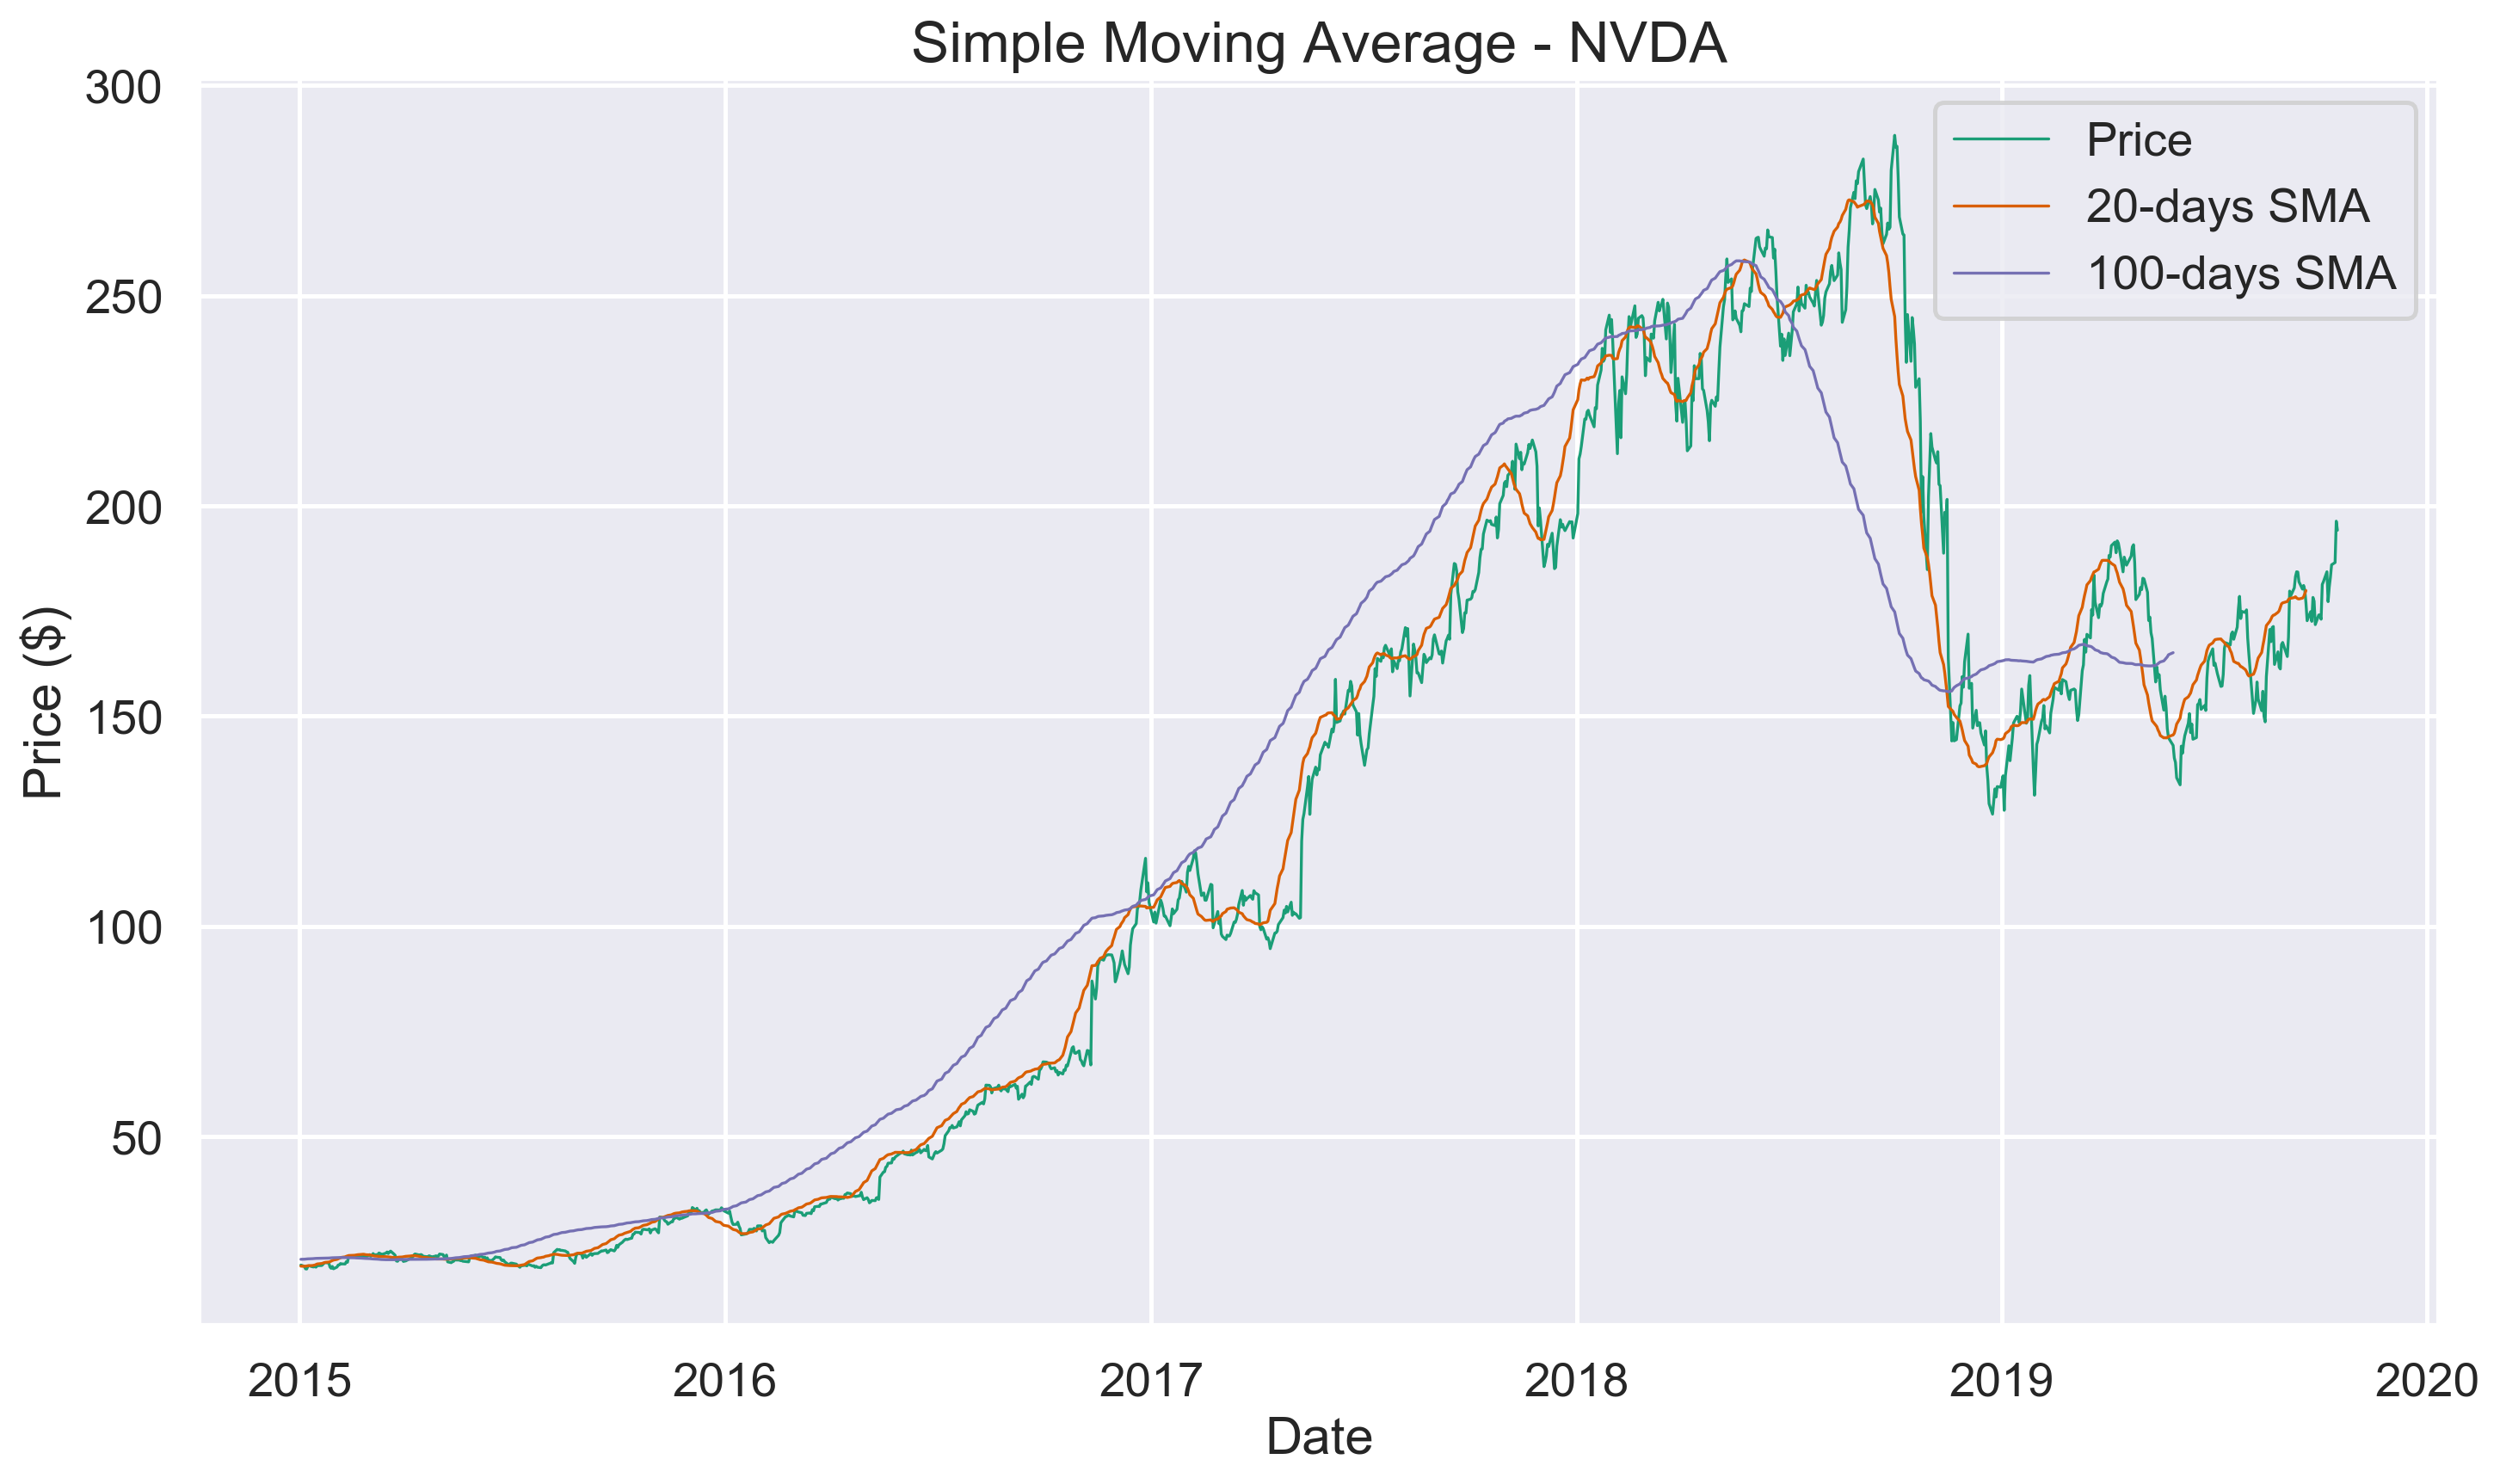

In [7]:
plt.plot(data[stock].index, data[stock]['adjusted_close'], label = 'Price')

plt.plot(data[stock].index, data[stock]['sma_20'], label = '20-days SMA')

plt.plot(data[stock].index, data[stock]['sma_100'], label = '100-days SMA')

plt.legend(loc = 'best')
plt.title('Simple Moving Average - ' + stock)
plt.xlabel('Date')
plt.ylabel('Price ($)')

plt.show()

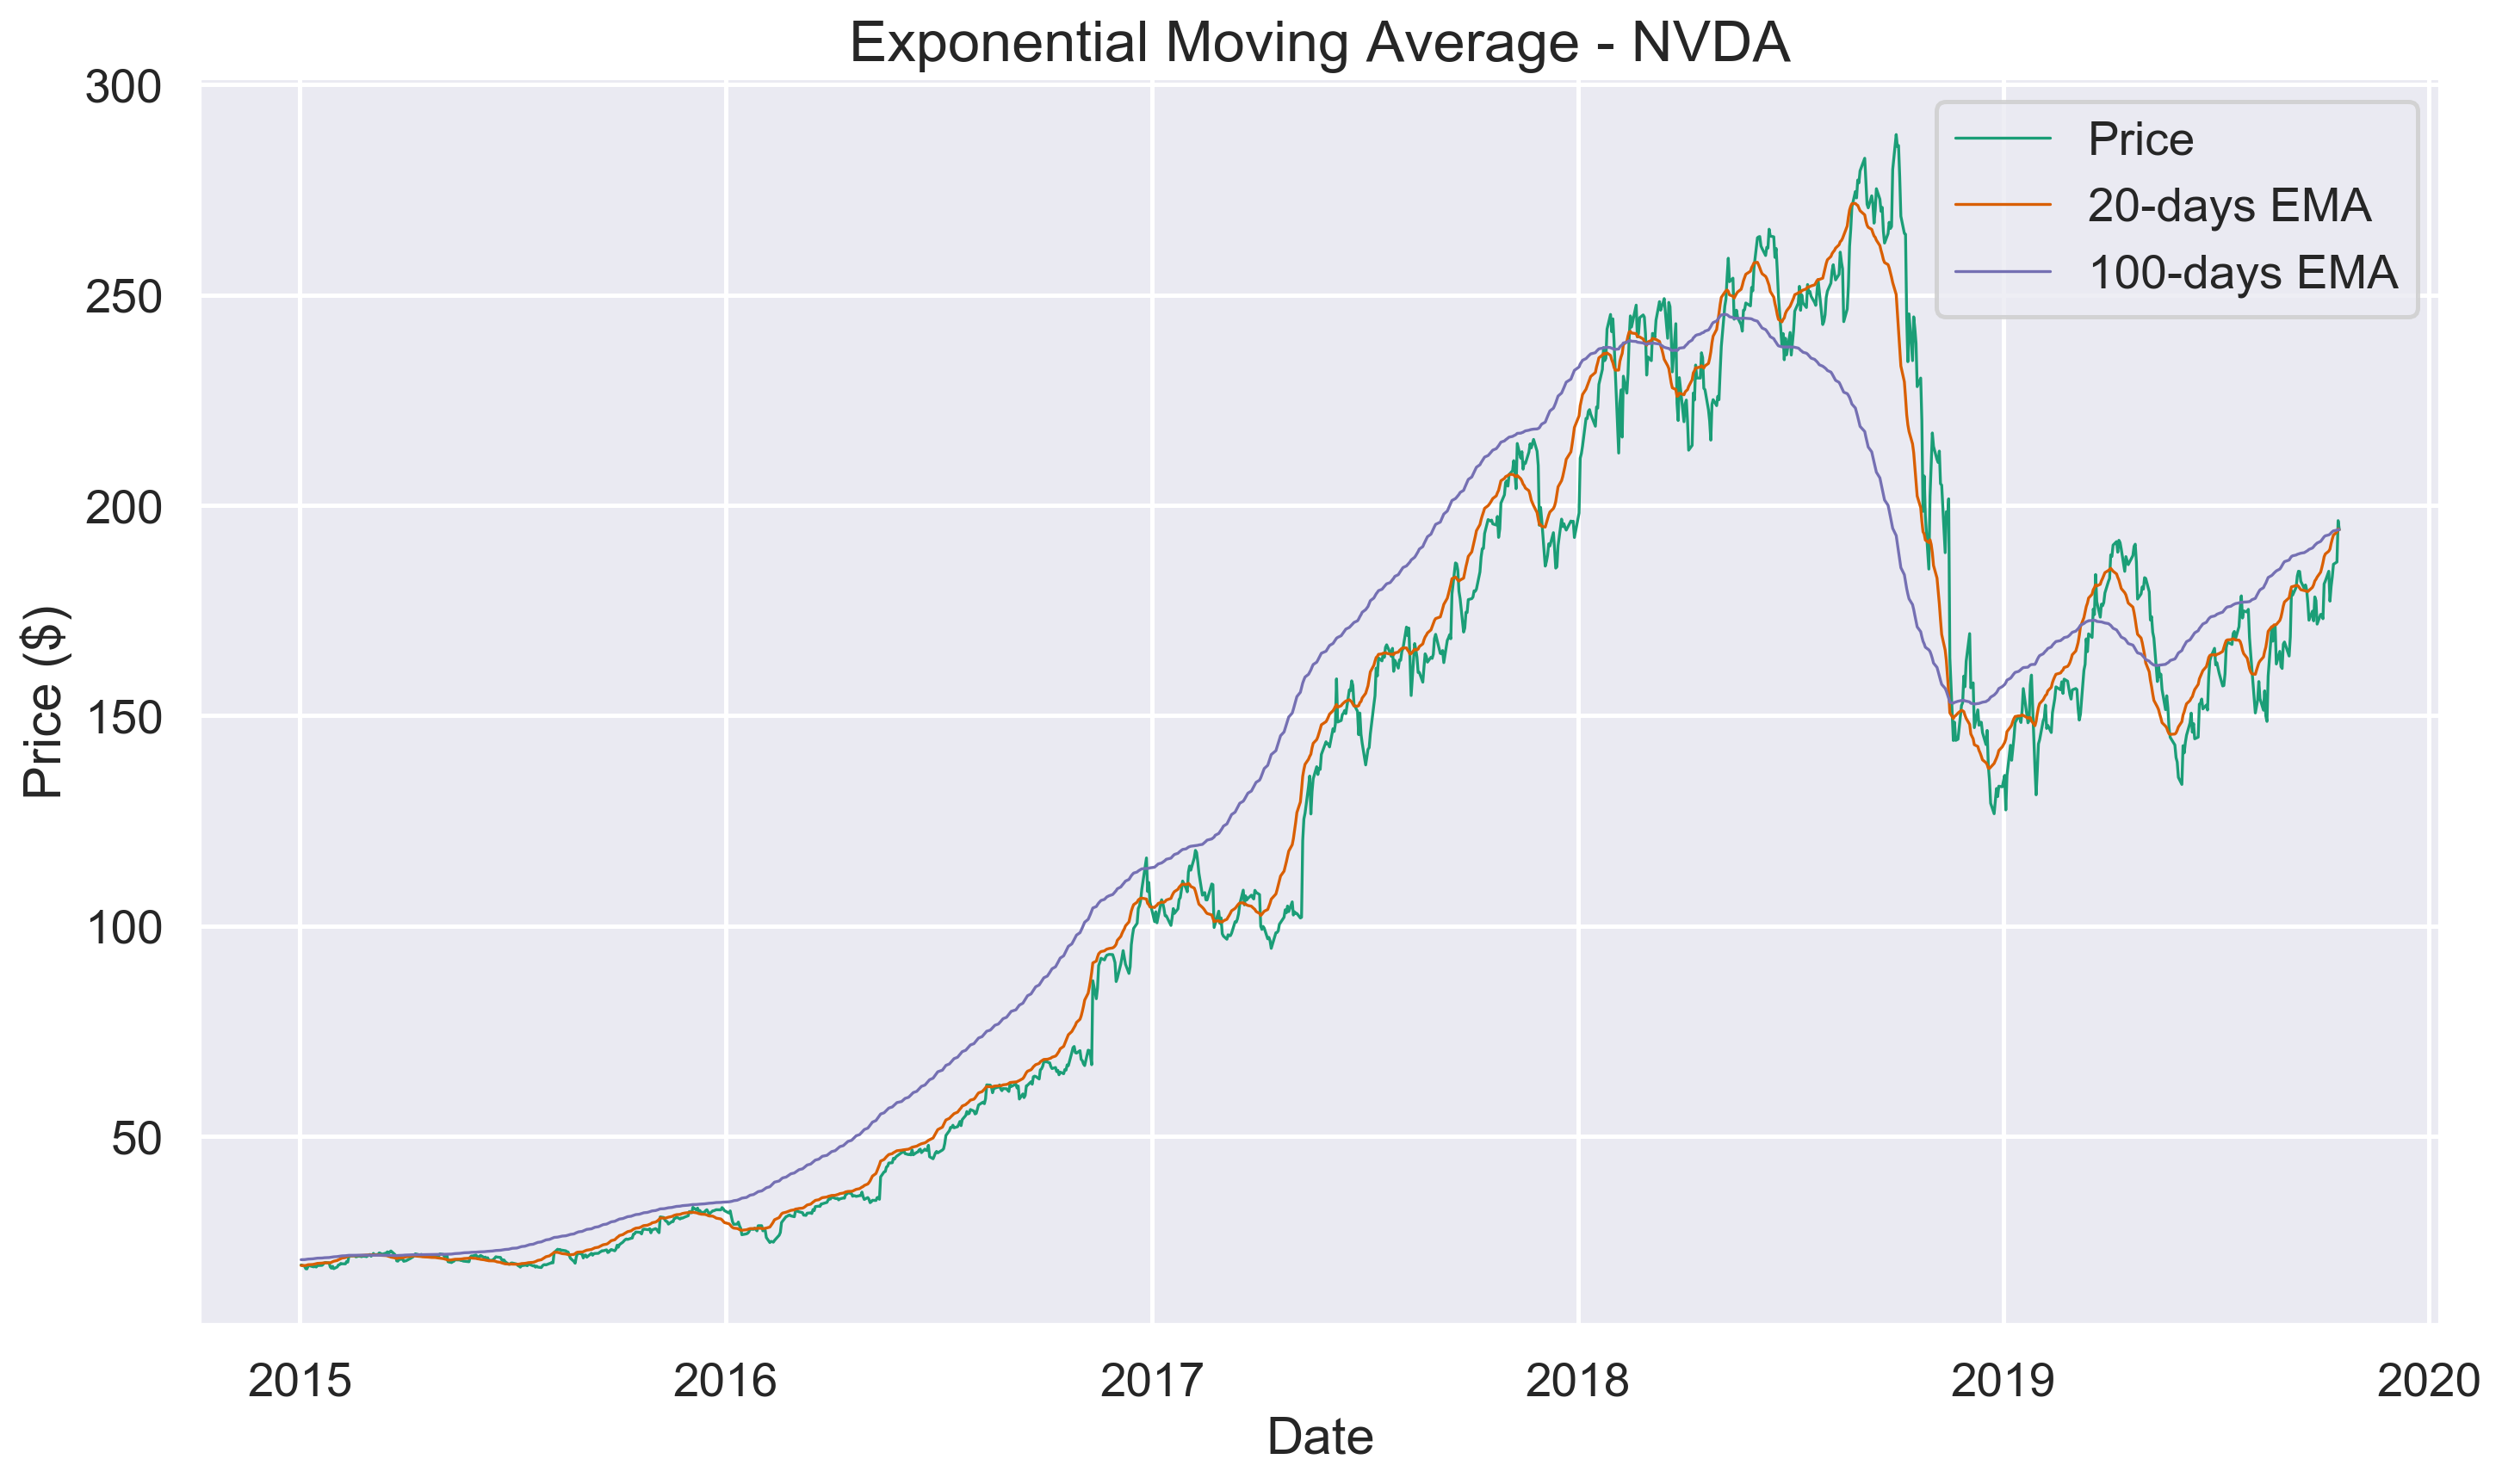

In [8]:
plt.plot(data[stock].index, data[stock]['adjusted_close'], label = 'Price')

plt.plot(data[stock].index, data[stock]['ema_20'], label = '20-days EMA')

plt.plot(data[stock].index, data[stock]['ema_100'], label = '100-days EMA')

plt.legend(loc = 'best')
plt.title('Exponential Moving Average - ' + stock)
plt.xlabel('Date')
plt.ylabel('Price ($)')

plt.show()

## Trading strategy

1. When the price timeseries p(t)<sup>*</sup> crosses the EMA timeseries e(t) from below, we will close any existing short position and go long (buy) one unit of the asset.

2. When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.

<sup>*</sup>p(t) is the price at time t

---

We will not work with actual values but rather with changes in the monetary value of the asset.

The most frequently used forms used are relative returns defined as:

* **Relative returns:** $$ \large r_{relative}(t) = \frac{p(t) − p(t−1)}{p(t−1)} $$

<br/>

* **Log returns:** $$ \large r(t) = \log\left(\frac{p(t)}{p(t−1)}\right) $$

<br/>

**Note:** Log-returns are additive and this facilitates treatment of our time-series, relative returns are not. We can see the additivity of log-returns in the following equation:

$$ \large r(t_1) + r(t_2) = \log\left(\frac{r(t_1)}{r(t_0)}\right) + \log\left(\frac{r(t_2)}{r(t_1)}\right) = \log\left(\frac{r(t_2)}{r(t_0)}\right)$$

<br/>

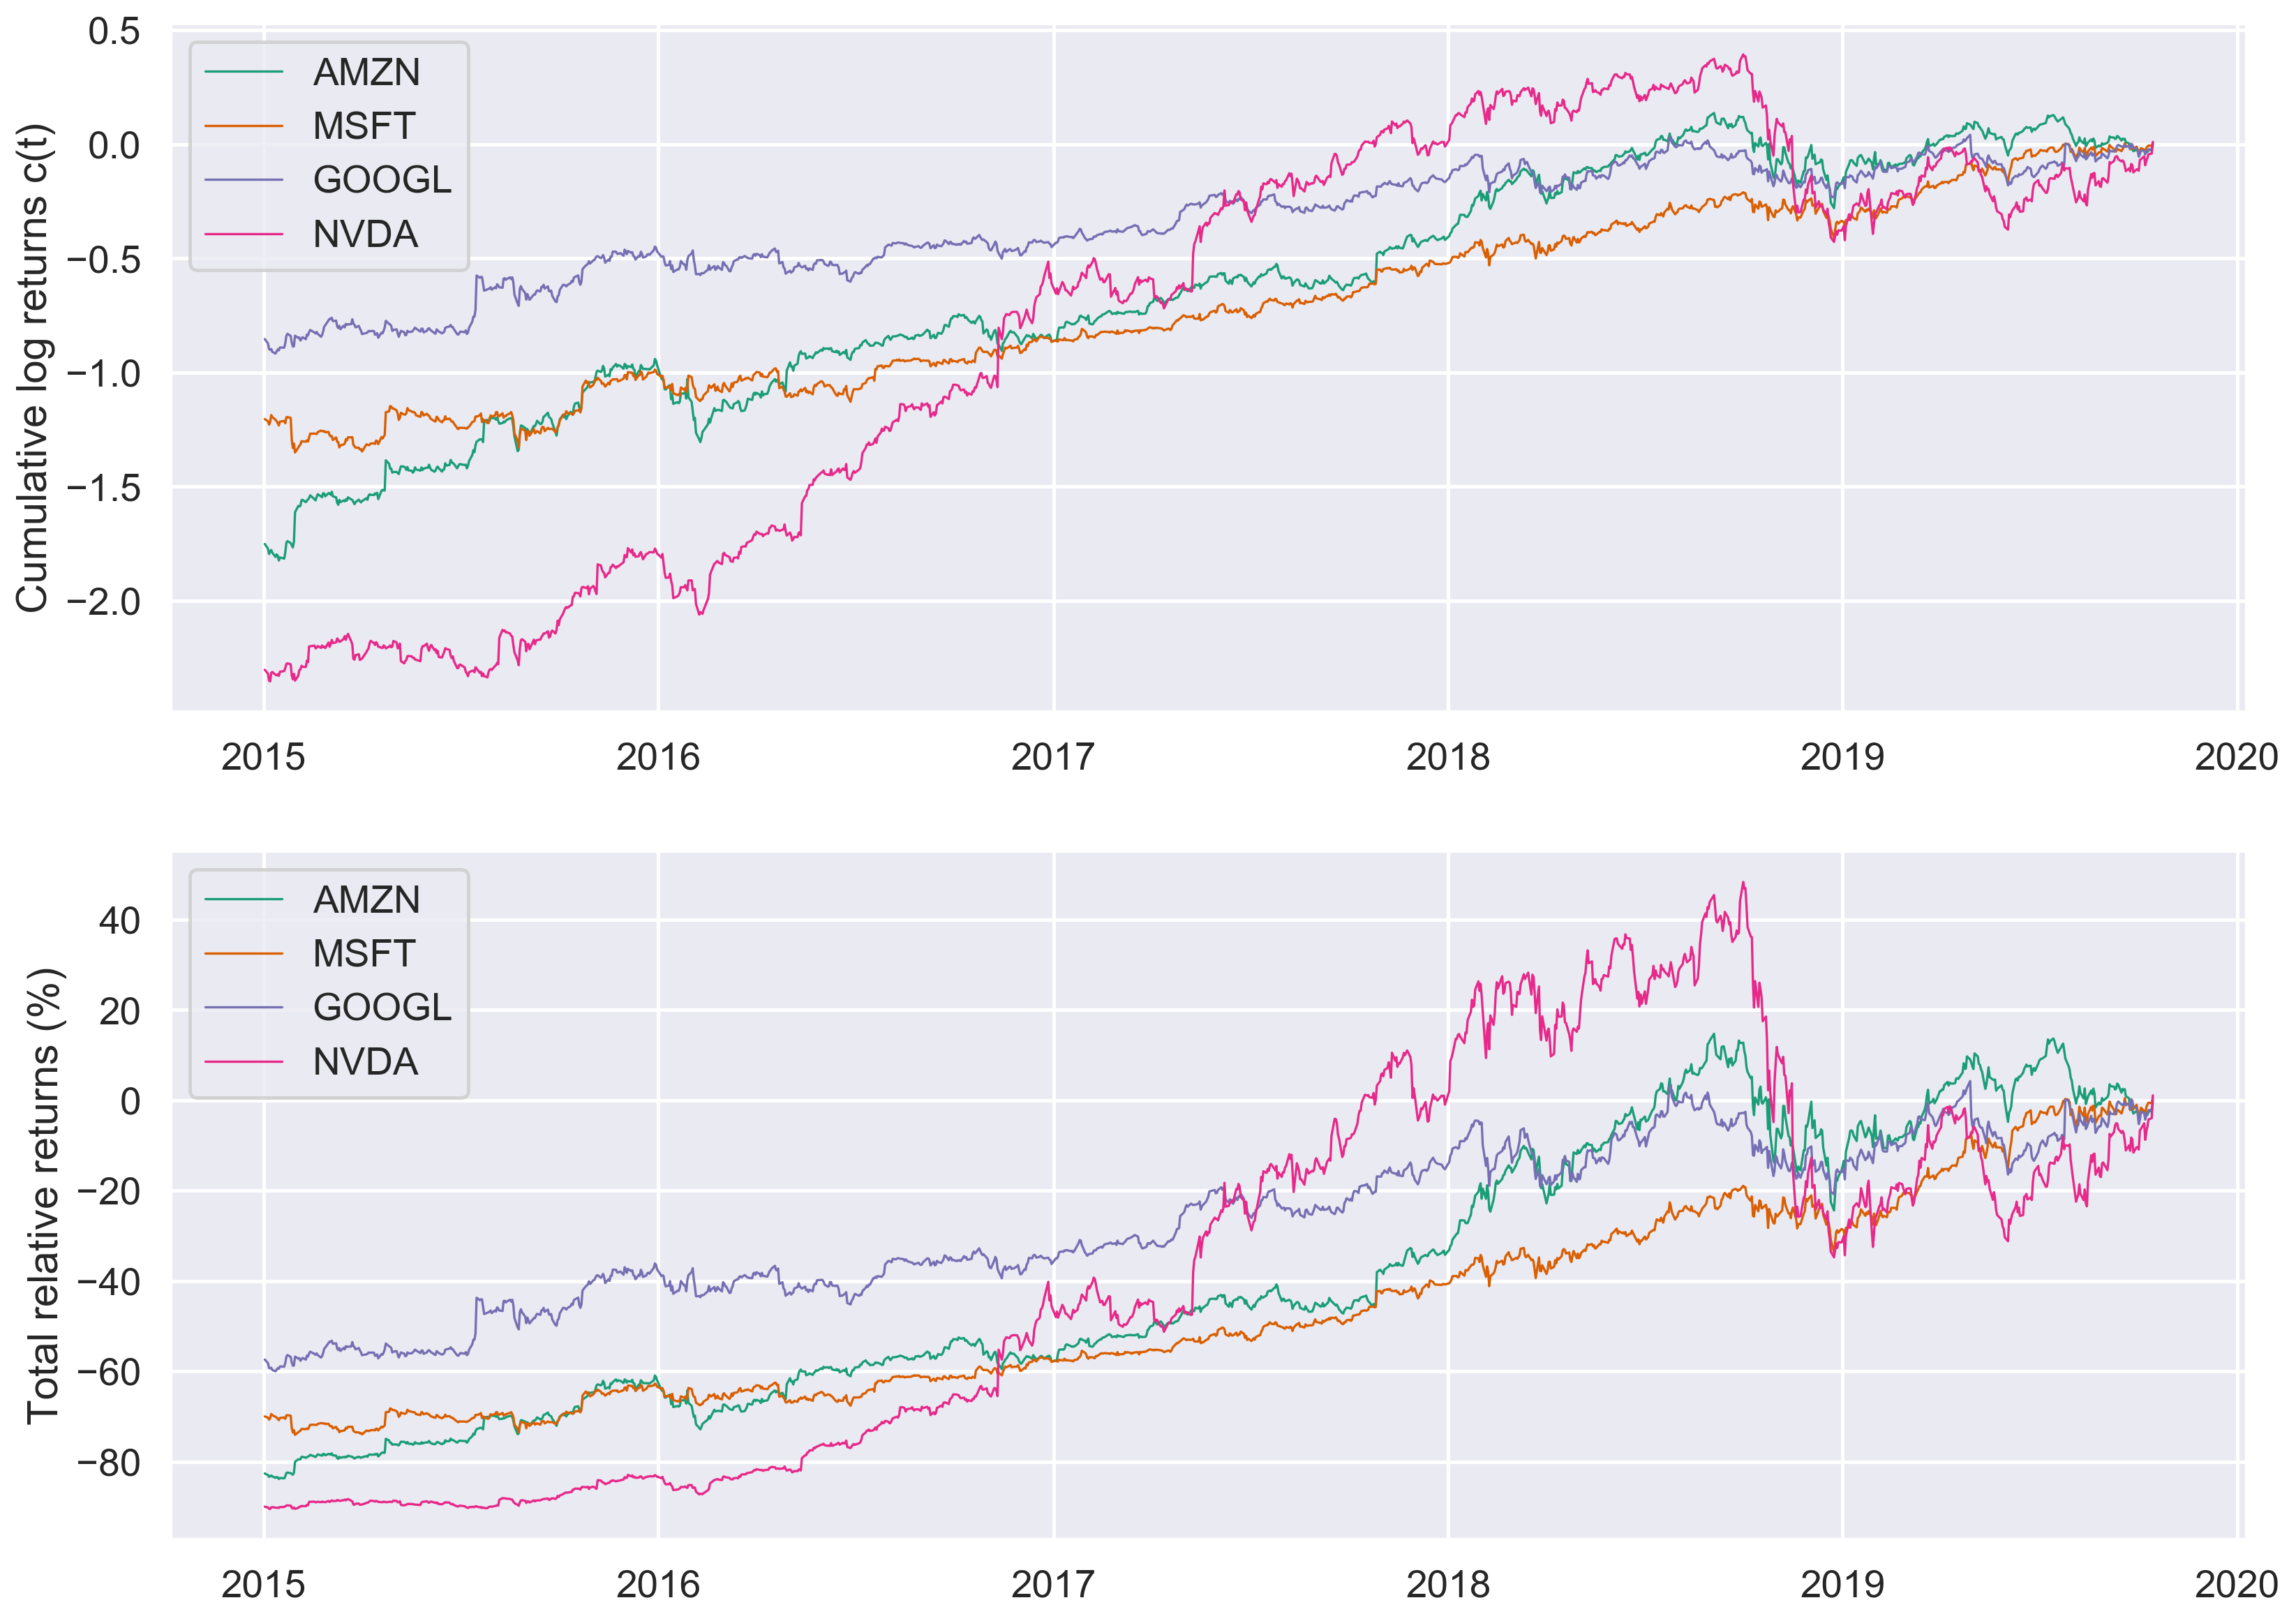

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16,12))

for stock in stocks:
    ax1.plot(data[stock].index, data[stock]['cumsum_log_returns'], label = stock)

ax1.set_ylabel('Cumulative log returns c(t)')
ax1.legend(loc = 'best')

for stock in stocks:
    ax2.plot(data[stock].index, 100 * (np.exp(data[stock]['cumsum_log_returns']) - 1), label = stock)

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc = 'best')

plt.show()

In [10]:
# Create a dataframe with log-returns

r_t = pd.DataFrame(columns = list(data.keys()), index = data[stock].index)

for stock in list(data.keys()):
    r_t[stock] = data[stock]['log_returns']

r_t = r_t.transpose()

r_t.iloc[:, :10]

,2019-10-16,2019-10-15,2019-10-14,2019-10-11,2019-10-10,2019-10-09,2019-10-08,2019-10-07,2019-10-04,2019-10-03
AMZN,NaN,-0.005670,-0.017667,-0.002601,-0.006755,0.001005,-0.009616,0.015794,0.004026,-0.008793
MSFT,NaN,0.008228,-0.014371,0.000931,-0.004161,-0.006202,-0.018766,0.010631,0.007266,-0.013411
GOOGL,NaN,-0.000612,-0.019895,-0.001693,-0.005146,-0.005863,-0.010257,0.015110,0.002240,-0.017939
NVDA,NaN,0.011061,-0.051409,-0.002899,-0.016043,-0.012757,-0.019445,0.039279,-0.012886,-0.003634


In [11]:
# Assume equal wieghts between assets

weights_matrix = pd.DataFrame(1 / len(data), index = data[stock].index, columns = list(data.keys()))

weights_matrix.iloc[:10, :]

,AMZN,MSFT,GOOGL,NVDA
2019-10-16,0.25,0.25,0.25,0.25
2019-10-15,0.25,0.25,0.25,0.25
2019-10-14,0.25,0.25,0.25,0.25
2019-10-11,0.25,0.25,0.25,0.25
2019-10-10,0.25,0.25,0.25,0.25
2019-10-09,0.25,0.25,0.25,0.25
2019-10-08,0.25,0.25,0.25,0.25
2019-10-07,0.25,0.25,0.25,0.25
2019-10-04,0.25,0.25,0.25,0.25
2019-10-03,0.25,0.25,0.25,0.25


## Portfolio returns

**Note** that we are only interested in the diagonal, which is where the dates in the row-index and the column-index match.

In [12]:
temp_var = weights_matrix.dot(r_t)

temp_var.head().iloc[:10, :10]

,2019-10-16,2019-10-15,2019-10-14,2019-10-11,2019-10-10,2019-10-09,2019-10-08,2019-10-07,2019-10-04,2019-10-03
2019-10-16,NaN,0.003252,-0.025835,-0.001565,-0.008026,-0.005954,-0.014521,0.020204,0.000162,-0.010944
2019-10-15,NaN,0.003252,-0.025835,-0.001565,-0.008026,-0.005954,-0.014521,0.020204,0.000162,-0.010944
2019-10-14,NaN,0.003252,-0.025835,-0.001565,-0.008026,-0.005954,-0.014521,0.020204,0.000162,-0.010944
2019-10-11,NaN,0.003252,-0.025835,-0.001565,-0.008026,-0.005954,-0.014521,0.020204,0.000162,-0.010944
2019-10-10,NaN,0.003252,-0.025835,-0.001565,-0.008026,-0.005954,-0.014521,0.020204,0.000162,-0.010944


The numpy `np.diag` function is used to extract the diagonal and then a Series is constructed using the time information from the `r_t.transpose()` index

In [13]:
portfolio_log_returns = pd.Series(np.diag(temp_var), index = r_t.transpose().index)

portfolio_log_returns.tail()

2015-01-08    0.007131
2015-01-07   -0.019054
2015-01-06   -0.004403
2015-01-05    0.023416
2015-01-02    0.016560
dtype: float64

Let us see what our cumulative log returns and the total relative returns for this portfolio look like

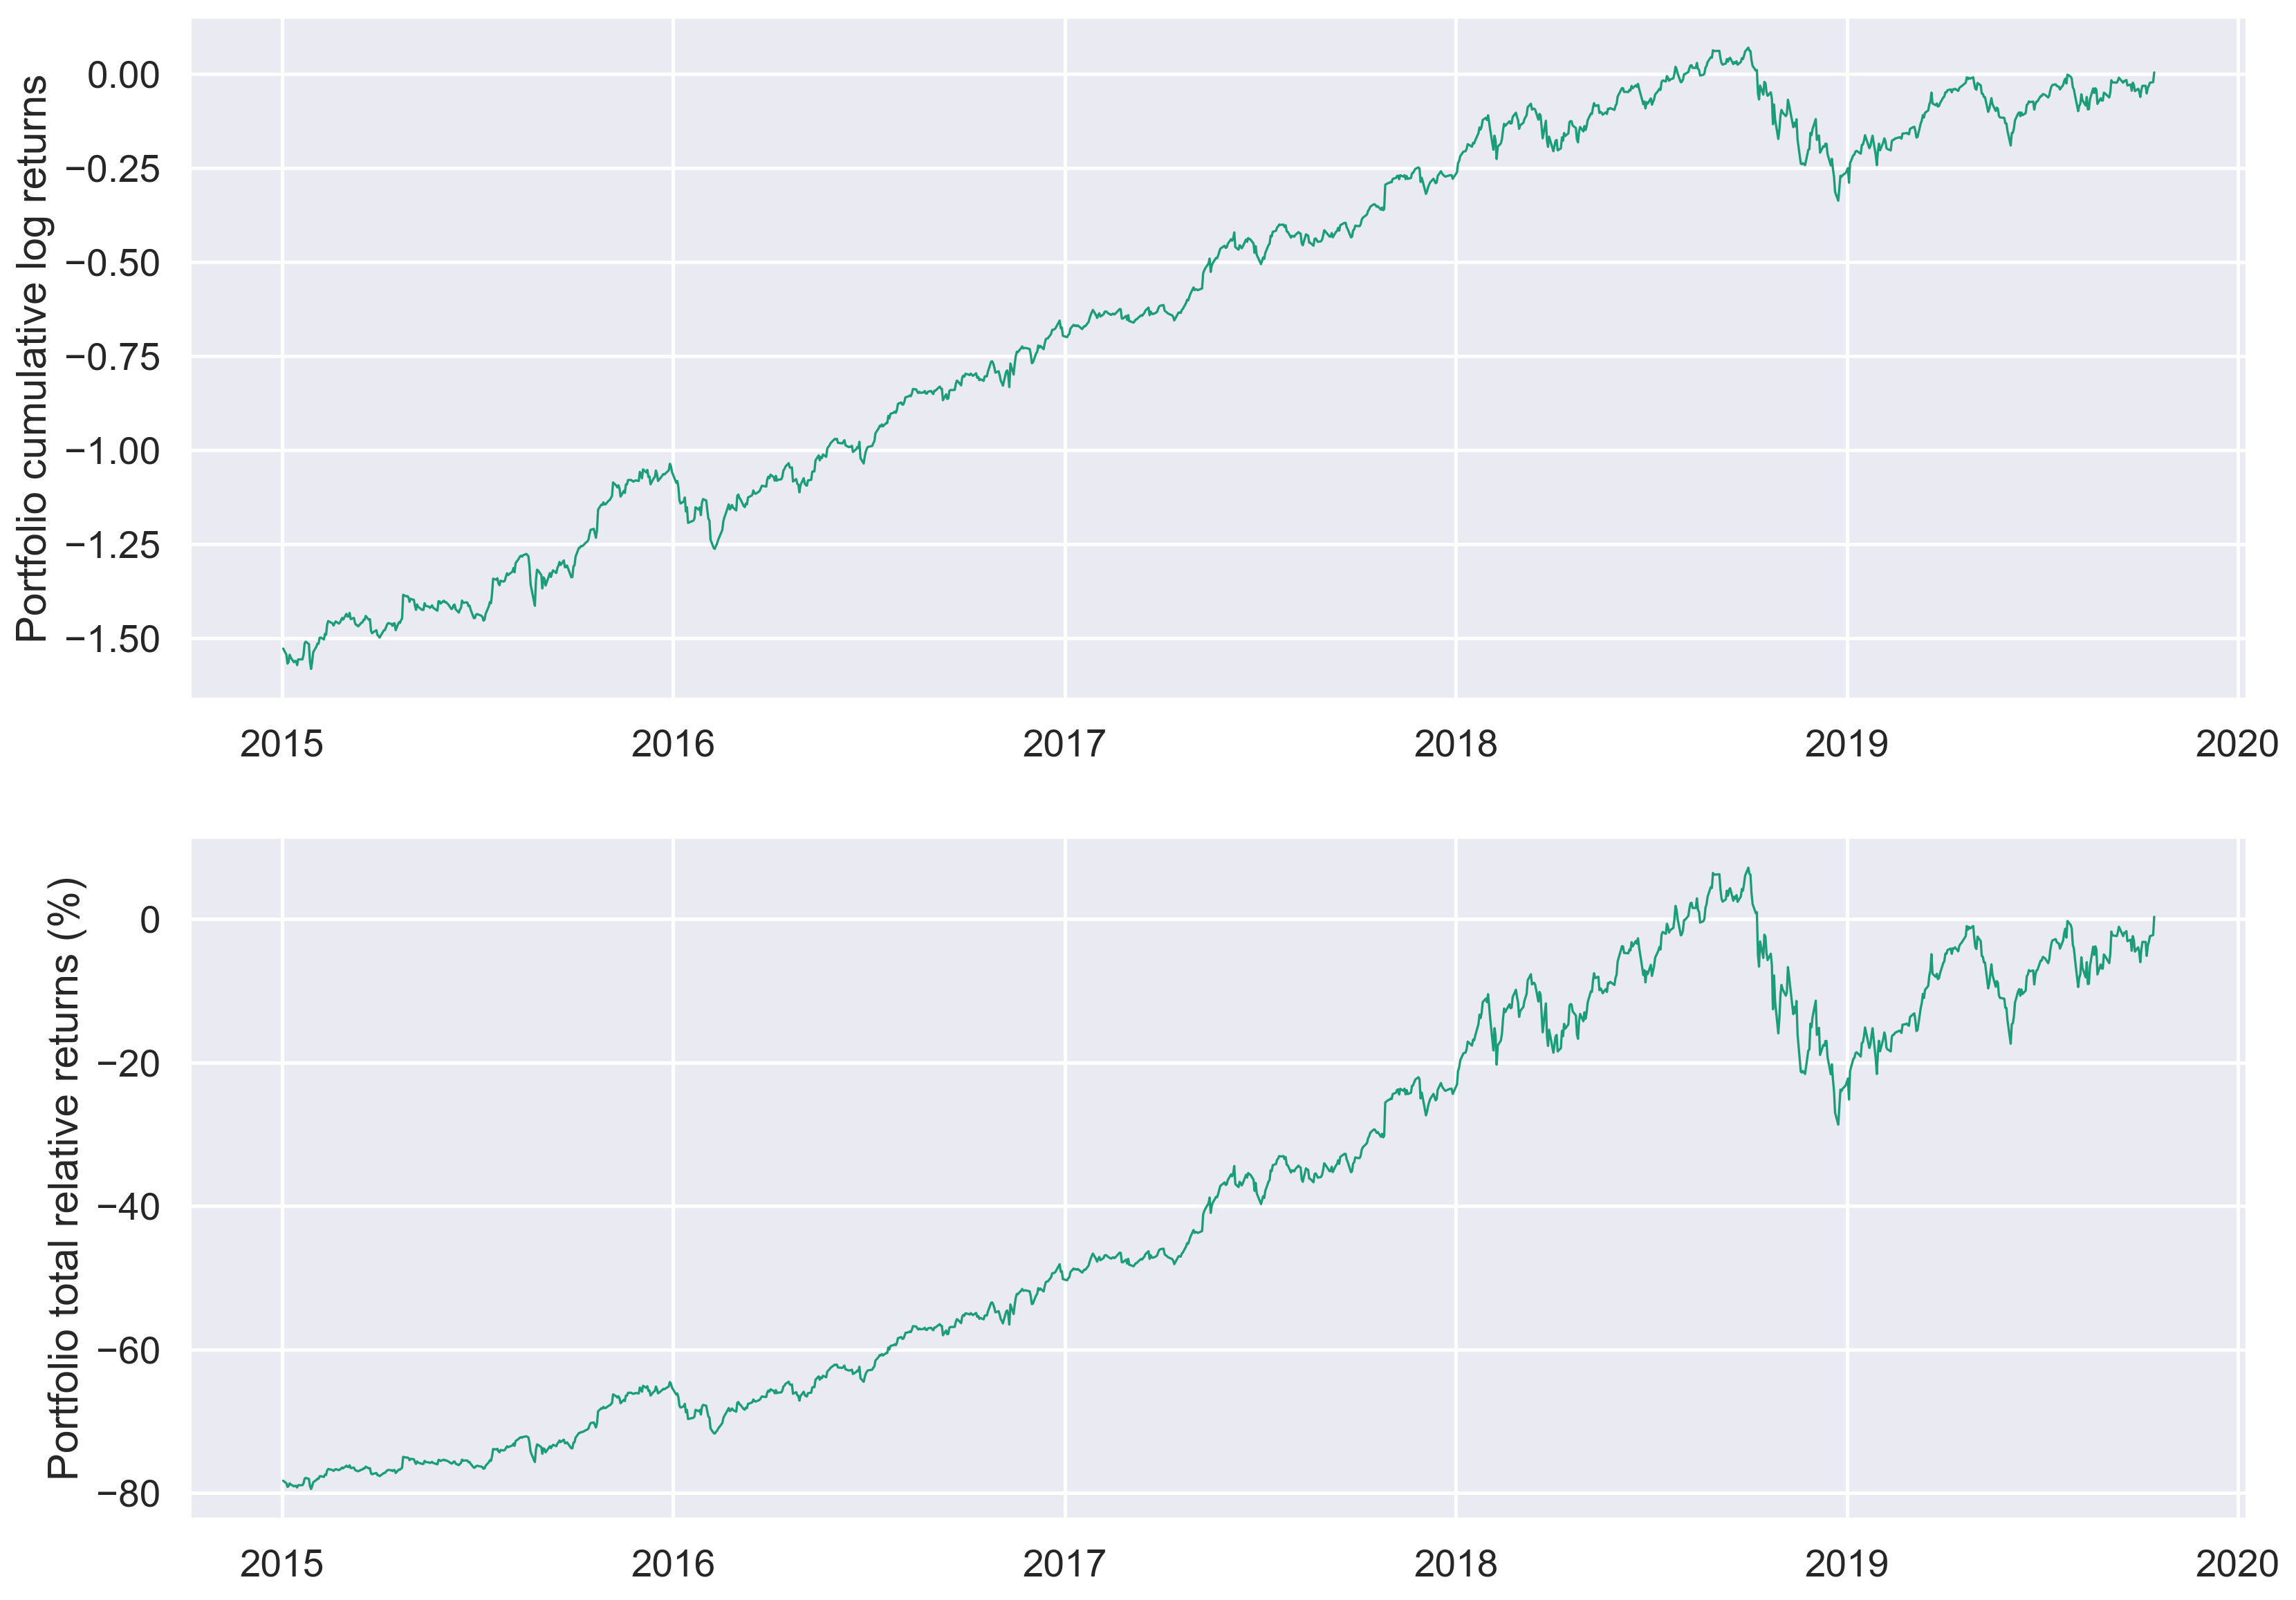

In [14]:
total_relative_returns = (np.exp(portfolio_log_returns.cumsum()) - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio cumulative log returns')

ax2.plot(total_relative_returns.index, 100 * total_relative_returns)
ax2.set_ylabel('Portfolio total relative returns (%)')

plt.show()

In [15]:
# Calculating the time-related parameters of the simulation

days_per_year = 52 * 5

total_days_in_simulation = data[stock].shape[0]

number_of_years = total_days_in_simulation / days_per_year

# The last data point will give us the total portfolio return

total_portfolio_return = total_relative_returns[-1]

# Average portfolio return assuming compunding of returns

average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('\n\nTotal portfolio return is: ' +
      '{:5.2f}'.format(100 * total_portfolio_return) + '%')

print('\n\nAverage yearly return is: ' +
      '{:5.2f}'.format(100 * average_yearly_return) + '%\n\n')



Total portfolio return is: -78.30%


Average yearly return is: -28.06%


